In [1]:
import sys
sys.path.insert(0, '../scripts')

import numpy as np
from reader import DC2StaticCoaddCatalog
from GCR import GCRQuery

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
catalog = DC2StaticCoaddCatalog()

In [4]:
sorted(catalog.list_all_quantities())

['dec',
 'mag_Y_lsst',
 'mag_g_lsst',
 'mag_i_lsst',
 'mag_r_lsst',
 'mag_u_lsst',
 'mag_z_lsst',
 'magerr_Y_lsst',
 'magerr_g_lsst',
 'magerr_i_lsst',
 'magerr_r_lsst',
 'magerr_u_lsst',
 'magerr_z_lsst',
 'ra']

In [12]:
sorted(catalog.list_all_native_quantities())[:20]

['base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_flux',
 'base_Blendedness_abs_flux_child',
 'base_Blendedness_abs_flux_parent',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_xy',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_flag',
 'base_Blendedness_flag_noCentroid',
 'base_Blendedness_flag_noShape',
 'base_Blendedness_old',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_flux',
 'base_Blendedness_raw_flux_child',
 'base_Blendedness_raw_flux_parent',
 'base_Blendedness_raw_parent_xx']

In [5]:
catalog.available_tract_patches[:10]

[{'tract': 4636, 'patch': 4},
 {'tract': 4636, 'patch': 5},
 {'tract': 4636, 'patch': 6},
 {'tract': 4636, 'patch': 7},
 {'tract': 4636, 'patch': 14},
 {'tract': 4636, 'patch': 15},
 {'tract': 4636, 'patch': 17},
 {'tract': 4637, 'patch': 0},
 {'tract': 4637, 'patch': 1},
 {'tract': 4637, 'patch': 2}]

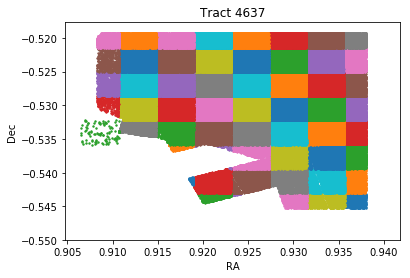

In [6]:
tract_number = 4637
for d in catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==tract_number, 'tract')], return_iterator=True):
    plt.scatter(d['ra'], d['dec'], s=2);
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Tract {}'.format(tract_number));

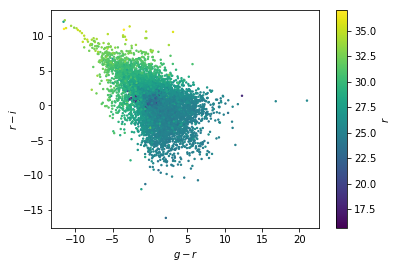

In [7]:
tract_number = 4637
mags = ['mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst']
d = catalog.get_quantities(mags, 
                           filters=[GCRQuery(*((np.isfinite, key) for key in mags))], 
                           native_filters=[(lambda x: x==tract_number, 'tract')])
c = plt.scatter(d['mag_g_lsst'] - d['mag_r_lsst'], d['mag_r_lsst'] - d['mag_i_lsst'], s=2, c=d['mag_r_lsst']);
plt.colorbar(c, label='$r$')
plt.xlabel('$g-r$');
plt.ylabel('$r-i$');


Here's an example from https://github.com/LSSTDESC/DC2_Repo/blob/issues/155/Validation/lensing_distributions.ipynb

In [8]:
catalog.add_quantity_modifier('i_mag_cmodel', (lambda x: -2.5 * np.log10(x) + 27.0, 'i_modelfit_CModel_flux'), overwrite=True)
catalog.add_quantity_modifier('i_SN_cmodel', (np.divide, 'i_modelfit_CModel_flux', 'i_modelfit_CModel_fluxSigma'), overwrite=True)
catalog.add_quantity_modifier('HSM_res', 'ext_shapeHSM_HsmShapeRegauss_resolution', overwrite=True)
catalog.add_quantity_modifier('HSM_ell', (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), overwrite=True)

In [9]:
lensing_cuts = [
    GCRQuery('detect_isPrimary'),
    ~GCRQuery('deblend_skipped'),
    ~GCRQuery('base_PixelFlags_flag_edge'),
    ~GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_saturatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_crCenter'),
    ~GCRQuery('base_PixelFlags_flag_bad'),
    ~GCRQuery('base_PixelFlags_flag_suspectCenter'),
    ~GCRQuery('base_PixelFlags_flag_clipped'),
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),
    GCRQuery('i_SN_cmodel >= 10'),
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('i_mag_cmodel < 24.5'),
    GCRQuery('base_Blendedness_abs_flux < 10**(-0.375)'),
]

In [10]:
tract_number = 4637
quantities = ['i_mag_cmodel', 'i_SN_cmodel', 'HSM_res', 'HSM_ell']
d = catalog.get_quantities(quantities, 
                           filters=lensing_cuts, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

/global/homes/y/yymao/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/global/homes/y/yymao/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


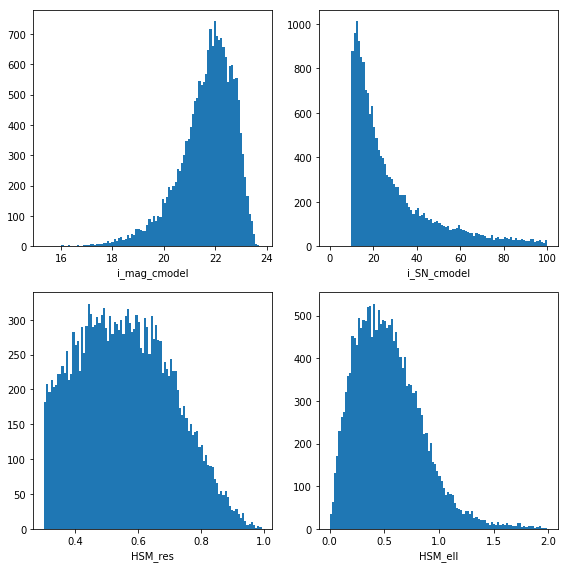

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
for ax_this, quantity in zip(ax.flat, quantities):
    ax_this.hist(d[quantity], 100, range=([0,100] if quantity=='i_SN_cmodel' else None))
    ax_this.set_xlabel(quantity)
fig.tight_layout()